In [1]:
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mutual_info_score
from darts.models import ExponentialSmoothing, Prophet, RandomForest, RNNModel
from darts.metrics import mape
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/harshmaniar/.pyenv/versions/3.9.10/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-16 23:53:37 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


In [2]:
# Data Cleaning
df = pd.read_csv('walmart_cleaned.csv')
df = df.drop(columns = ['Remove'])

df.head()

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315
4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,151315


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day
df

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Year,Day
0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315,2,2010,5
1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315,2,2010,5
2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315,2,2010,5
3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315,2,2010,5
4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315,2,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,10,2012,26
421566,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,10,2012,26
421567,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,10,2012,26
421568,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,10,2012,26


In [4]:
df.isna().sum()

Store           0
Date            0
IsHoliday       0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Month           0
Year            0
Day             0
dtype: int64

In [5]:
# Removed all the negative and technically 'incorrect' data
df = df[df.Weekly_Sales >= 0]
df = df[df.Temperature >= 0]
df = df[df.MarkDown2 >= 0]
df = df[df.MarkDown3>= 0]
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,418660.0,22.199651,12.790081,1.000,11.000000,22.000000,33.000000,45.000000
IsHoliday,418660.0,0.069968,0.255094,0.000,0.000000,0.000000,0.000000,1.000000
Dept,418660.0,44.243840,30.508595,1.000,18.000000,37.000000,74.000000,99.000000
Weekly_Sales,418660.0,16027.102319,22726.505779,0.000,2116.497500,7658.065000,20266.080000,693099.360000
Temperature,418660.0,60.062170,18.440017,5.540,46.660000,62.070000,74.250000,100.140000
Fuel_Price,418660.0,3.359362,0.458406,2.472,2.931000,3.452000,3.735000,4.468000
MarkDown1,418660.0,2576.223052,6057.124707,0.000,0.000000,0.000000,2753.900000,88646.760000
MarkDown2,418660.0,882.194699,5086.067782,0.000,0.000000,0.000000,2.630000,104519.540000
MarkDown3,418660.0,470.476286,5544.253468,0.000,0.000000,0.000000,4.360000,141630.610000
MarkDown4,418660.0,1080.257751,3901.845590,0.000,0.000000,0.000000,415.360000,67474.850000


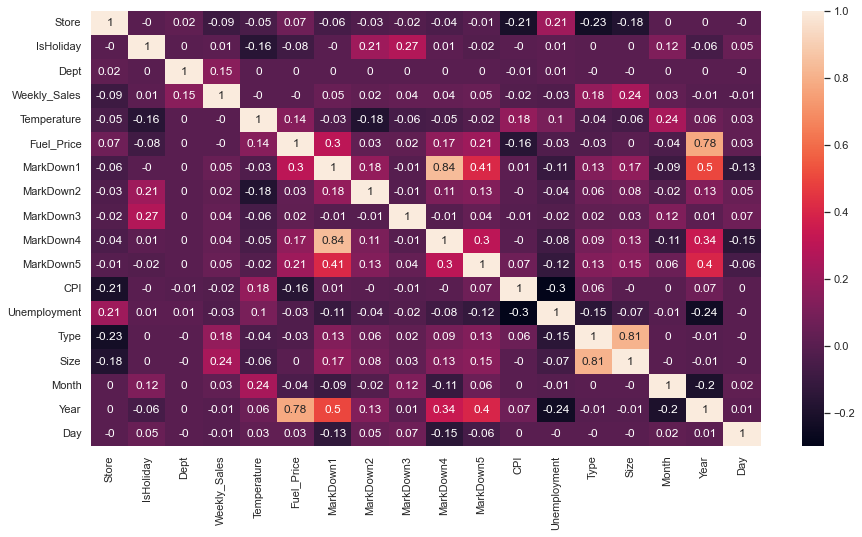

In [6]:
correlation_Matrix = df.corr().round(2)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(correlation_Matrix,annot = True)
plt.show()
## Insight: People buy more in bigger stores and dept has a positive correlation.

In [7]:
new_df = df.groupby(['Date'], as_index = False).mean()
new_df


,Date,Store,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Year,Day
0,2010-02-05,22.035957,0.0,44.144166,16876.145176,33.284630,2.717941,0.000000,0.000000,0.000000,0.000000,0.000000,167.357048,8.578049,2.412483,137427.979986,2.0,2010.0,5.0
1,2010-02-12,22.006443,1.0,44.331638,16390.912208,33.370444,2.695955,0.000000,0.000000,0.000000,0.000000,0.000000,167.401961,8.567855,2.415056,137675.080027,2.0,2010.0,12.0
2,2010-02-19,22.040390,0.0,44.288455,16249.714685,37.039727,2.673587,0.000000,0.000000,0.000000,0.000000,0.000000,167.372455,8.574993,2.411982,137274.186469,2.0,2010.0,19.0
3,2010-02-26,22.019028,0.0,44.082229,14940.686595,38.636031,2.685449,0.000000,0.000000,0.000000,0.000000,0.000000,167.724288,8.562098,2.412504,137355.873598,2.0,2010.0,26.0
4,2010-03-05,22.056199,0.0,44.019755,15964.821240,42.367490,2.731923,0.000000,0.000000,0.000000,0.000000,0.000000,167.680036,8.573890,2.414169,137556.273161,3.0,2010.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2012-09-28,22.227981,0.0,44.099932,14815.621125,68.163750,3.858017,4895.531619,19.071321,5.247659,1700.566721,4246.619665,175.983576,7.222354,2.404810,136080.131775,9.0,2012.0,28.0
139,2012-10-05,22.257162,0.0,44.518369,16032.036903,65.449390,3.848439,5043.202406,0.000000,19.990903,2809.727752,3622.691921,175.992008,6.940704,2.408493,136484.789350,10.0,2012.0,5.0
140,2012-10-12,22.203760,0.0,44.574018,15484.696200,57.678090,3.896989,1956.173911,0.000000,16.775955,557.068587,5608.688929,176.161362,6.949037,2.406512,136284.739846,10.0,2012.0,12.0
141,2012-10-19,22.258907,0.0,44.128266,15311.314544,60.148140,3.878274,1916.917034,0.000000,13.201208,432.077075,3307.257964,176.306335,6.947697,2.400407,135939.205972,10.0,2012.0,19.0


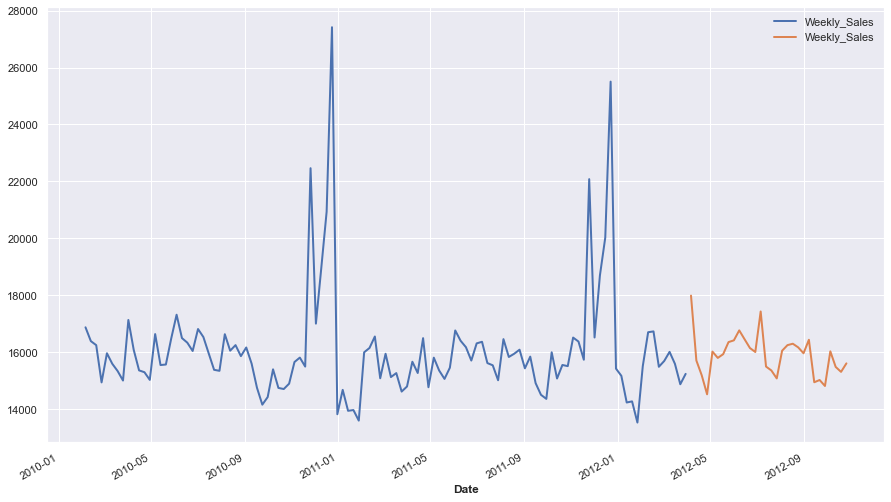

In [8]:
relevant_features = ['Dept', 'Size', 'Store', 'Type', 'IsHoliday', 'Month', 'Year']
series = TimeSeries.from_dataframe(new_df,'Date','Weekly_Sales', fill_missing_dates = False,freq=None)
train,test = series.split_before(0.80)
train.plot()
test.plot()

3.1394657692637806

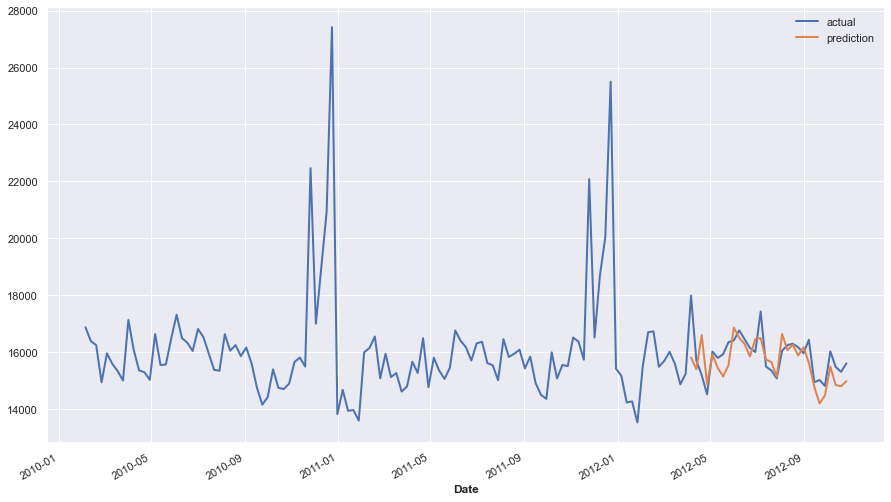

In [9]:

model = ExponentialSmoothing()
model.fit(train)
es_predict = model.predict(len(test))
series.plot(label='actual')
es_predict.plot(label ='prediction')
plt.legend()
exponential_smoothing_score = mape(test,es_predict)
exponential_smoothing_score


2022-06-16 23:53:42 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-06-16 23:53:42 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3.2766487678194753

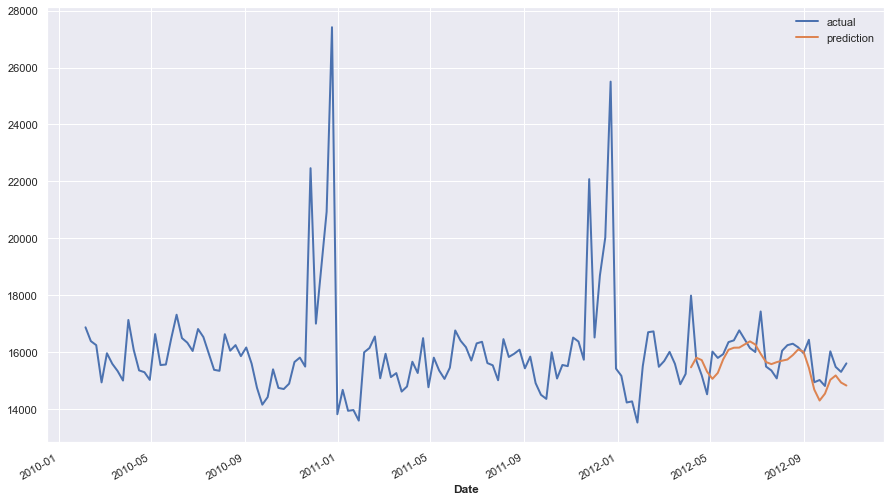

In [10]:
model = Prophet()
model.fit(train)
es_predict = model.predict(len(test))
series.plot(label='actual')
es_predict.plot(label ='prediction')
plt.legend()
score = mape(test,es_predict)
score
